# Classificazione di frutti esotici

Bibliography: AIAMA, Artificial Intelligence, A Modern Approach (4th ed.)

In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score,log_loss, confusion_matrix, classification_report
import seaborn as sns

In [244]:
RANDOM_SEED = 0

In [245]:
df = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv")
df.head()

,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88


In [246]:
df.shape

(500, 6)

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Frutto                 500 non-null    object 
 1   Peso (g)               500 non-null    float64
 2   Diametro medio (mm)    500 non-null    float64
 3   Lunghezza media (mm)   500 non-null    float64
 4   Durezza buccia (1-10)  500 non-null    float64
 5   Dolcezza (1-10)        500 non-null    float64
dtypes: float64(5), object(1)
memory usage: 23.6+ KB


We don't see any missing data:

In [248]:
df.isna().sum()

,0
Frutto,0
Peso (g),0
Diametro medio (mm),0
Lunghezza media (mm),0
Durezza buccia (1-10),0
Dolcezza (1-10),0


Visualize data and correlations

In [249]:
target = "Frutto"
colors = {
    'Mela': 'red',
    'Banana': 'yellow',
    'Arancia': 'orange',
    'Uva': 'purple',
    'Kiwi': 'green'
}

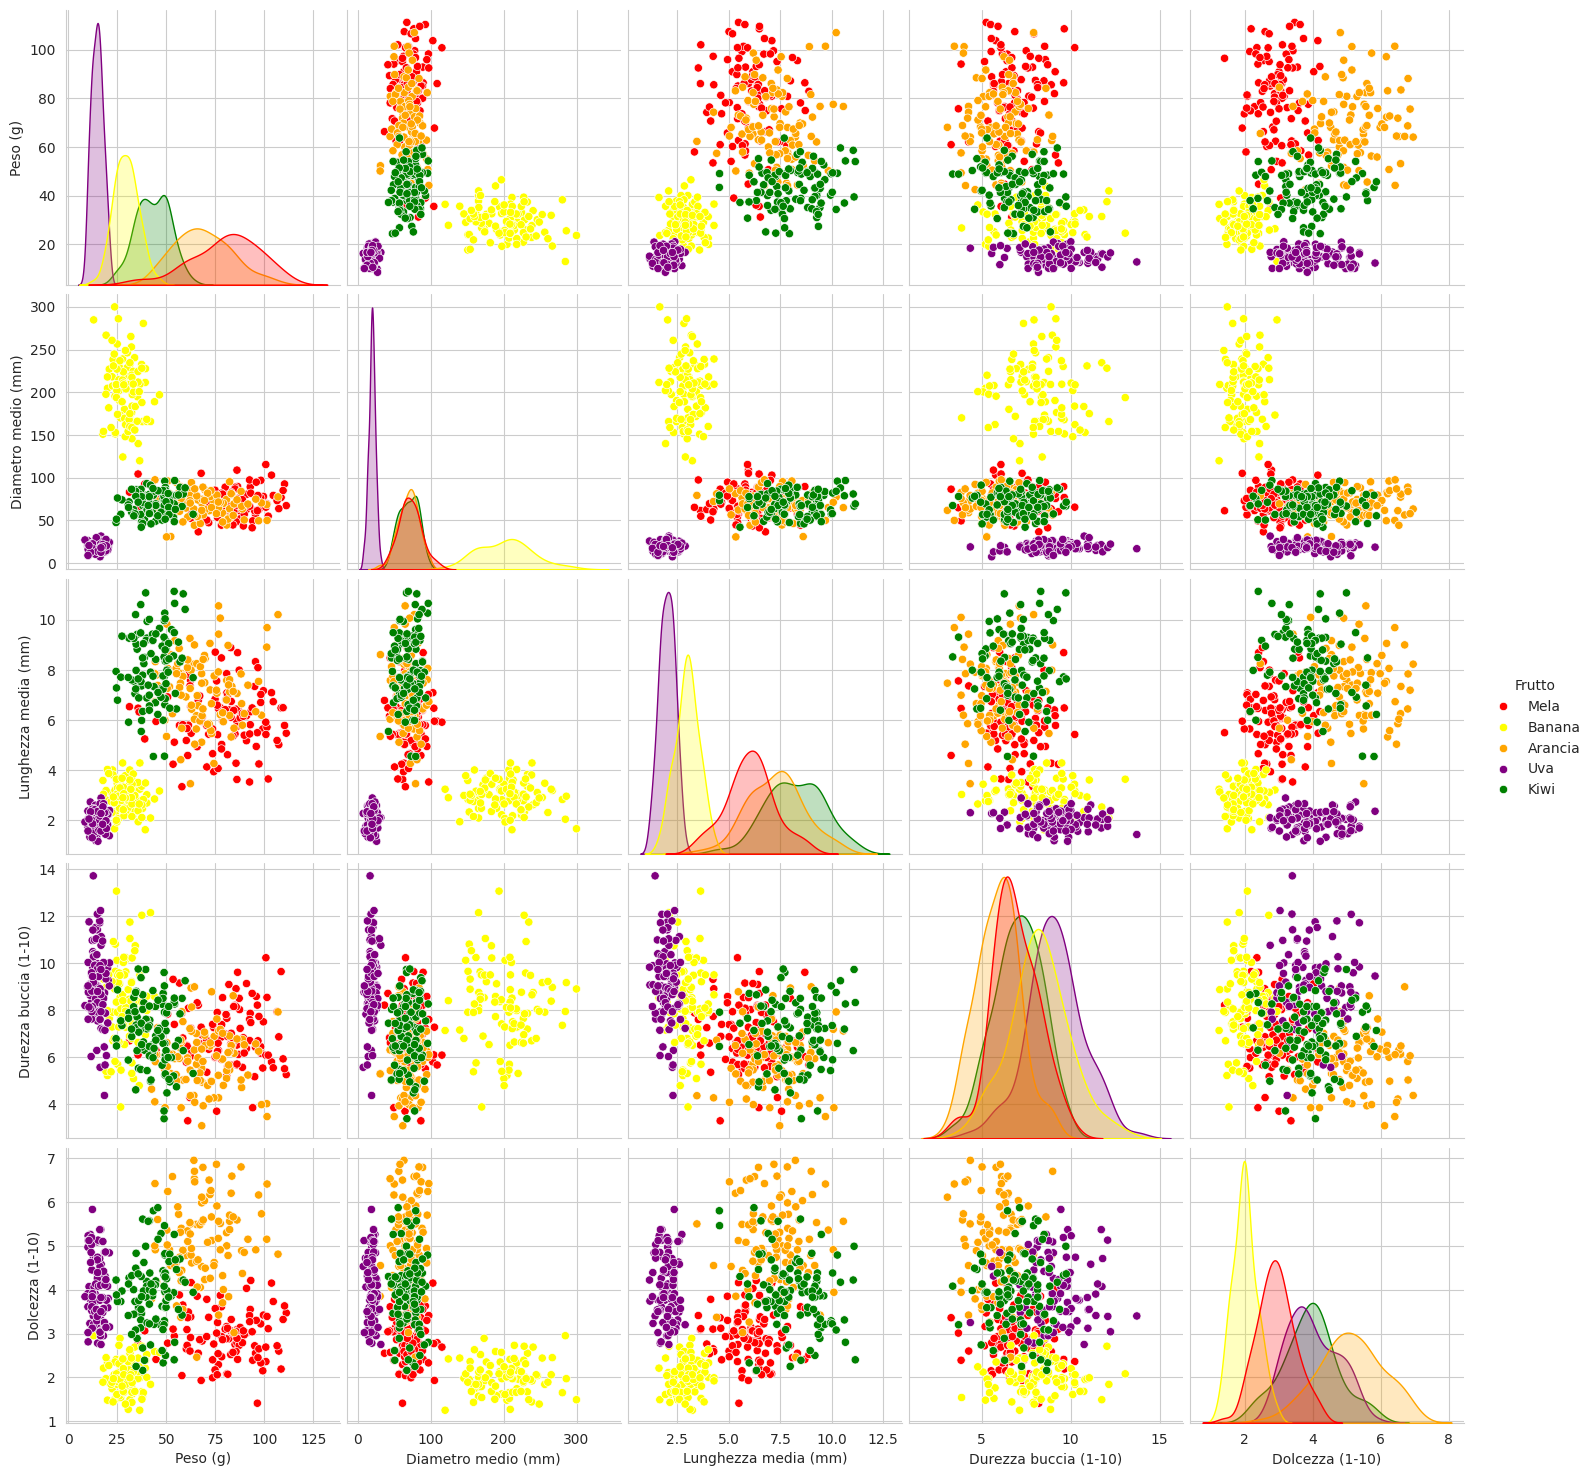

In [250]:
sns.set_style("whitegrid");
sns.pairplot(df, hue=target, height=3, palette=colors);
plt.show()

In [251]:
df[target].unique()

array(['Mela', 'Banana', 'Arancia', 'Uva', 'Kiwi'], dtype=object)

The classes are well balanced:

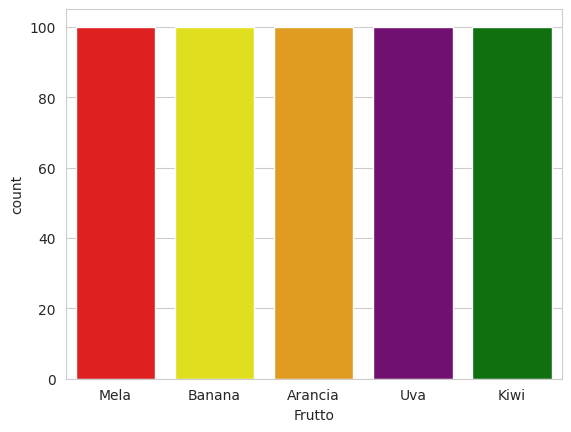

In [252]:
sns.countplot(df, x=target, hue=target, palette=colors)
plt.show()

In [253]:
X = df.drop(target, axis=1).values
y = df[target].values

In [254]:
X.shape

(500, 5)

In [255]:
y.shape

(500,)

In [256]:
def knn_cv(X, y, model):
  accuracy = []
  f1 = []
  loss = []

  kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

  # iterate cross-validation
  for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # apply feature scaling by using normalization:
    mms = MinMaxScaler()
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)

    knn = model
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    y_prob = knn.predict_proba(X_test)

    accuracy_test = accuracy_score(y_test, y_pred)
    f1_test = f1_score(y_test, y_pred, average="weighted")
    loss_test = log_loss(y_test, y_prob)

    accuracy.append(accuracy_test)
    f1.append(f1_test)
    loss.append(loss_test)

  return np.mean(accuracy), np.mean(f1), np.mean(loss)

In [257]:
def evaluate_k(k_max, metric="minkowski", weights="uniform"):
  results = []
  step = 2
  range_stop = k_max + 1

  for k in range(3, range_stop):
    model = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
    accuracy, f1, loss = knn_cv(X, y, model)
    print(f"k={k}, accuracy={accuracy:.4f}, f1={f1:.4f}, loss={loss:.4f}")
    result = (k, round(accuracy, 4), round(f1, 4), round(loss, 4))
    results.append(result)

  results_df = pd.DataFrame(results, columns=[['K', 'Accuracy','F1-score', 'Log loss']])

  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.plot(results_df['K'], results_df['F1-score'])
  plt.xlabel('K')
  plt.xticks(range(3, range_stop, step))
  plt.ylabel('F1-score')
  plt.title('F1-score vs. K')

  plt.subplot(1, 2, 2)
  plt.plot(results_df['K'], results_df['Log loss'])
  plt.xlabel('K')
  plt.xticks(range(3, range_stop, step))
  plt.ylabel('Log Loss')
  plt.title('Log Loss vs. K')

  plt.tight_layout()
  plt.show()

i) Evaluating the bare model, the best average result of the cross validation is:   
k=9, accuracy=0.9280, f1=0.9289, loss=0.3806

k=3, accuracy=0.9100, f1=0.9109, loss=0.9852
k=4, accuracy=0.9040, f1=0.9059, loss=0.7114
k=5, accuracy=0.9160, f1=0.9166, loss=0.5783
k=6, accuracy=0.9080, f1=0.9090, loss=0.5802
k=7, accuracy=0.9220, f1=0.9223, loss=0.5140
k=8, accuracy=0.9100, f1=0.9111, loss=0.3802
k=9, accuracy=0.9280, f1=0.9289, loss=0.3806
k=10, accuracy=0.9140, f1=0.9154, loss=0.3115
k=11, accuracy=0.9140, f1=0.9148, loss=0.3127
k=12, accuracy=0.9160, f1=0.9170, loss=0.3104
k=13, accuracy=0.9220, f1=0.9225, loss=0.3100
k=14, accuracy=0.9200, f1=0.9206, loss=0.2447
k=15, accuracy=0.9240, f1=0.9245, loss=0.2455
k=16, accuracy=0.9220, f1=0.9224, loss=0.2475
k=17, accuracy=0.9260, f1=0.9263, loss=0.2473
k=18, accuracy=0.9280, f1=0.9286, loss=0.2503
k=19, accuracy=0.9200, f1=0.9203, loss=0.2508


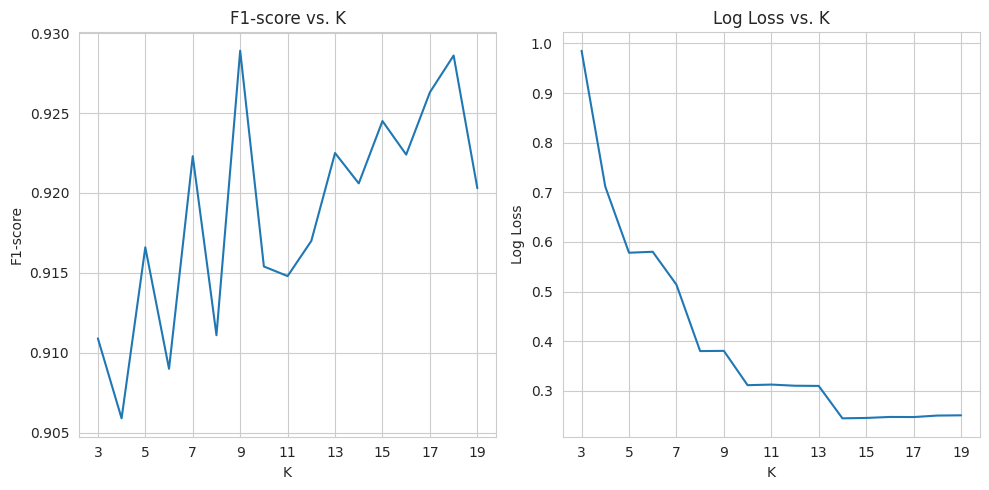

In [258]:
evaluate_k(19)

ii) We can try Manhattan distance, better when we're dealing with dissimilar properties (AIAMA, p. 706):

Evaluating the model using Manhattan, the best average result of the cross validation are:   

k=3, accuracy=0.9260, f1=0.9262, loss=0.9773    

k=15, accuracy=0.9240, f1=0.9244, loss=0.3239

k=21, accuracy=0.9240, f1=0.9247, loss=0.2616

k=25, accuracy=0.9260, f1=0.9263, loss=0.2006


k=3, accuracy=0.9260, f1=0.9262, loss=0.9773
k=4, accuracy=0.9160, f1=0.9176, loss=0.7791
k=5, accuracy=0.9120, f1=0.9128, loss=0.6501
k=6, accuracy=0.9120, f1=0.9128, loss=0.5840
k=7, accuracy=0.9120, f1=0.9121, loss=0.4488
k=8, accuracy=0.9060, f1=0.9072, loss=0.3816
k=9, accuracy=0.9140, f1=0.9147, loss=0.3814
k=10, accuracy=0.9140, f1=0.9146, loss=0.3827
k=11, accuracy=0.9220, f1=0.9225, loss=0.3827
k=12, accuracy=0.9120, f1=0.9127, loss=0.3842
k=13, accuracy=0.9200, f1=0.9206, loss=0.3207
k=14, accuracy=0.9100, f1=0.9108, loss=0.3232
k=15, accuracy=0.9240, f1=0.9244, loss=0.3239
k=16, accuracy=0.9140, f1=0.9146, loss=0.3255
k=17, accuracy=0.9200, f1=0.9205, loss=0.3249
k=18, accuracy=0.9220, f1=0.9224, loss=0.2573
k=19, accuracy=0.9240, f1=0.9244, loss=0.2602
k=20, accuracy=0.9220, f1=0.9229, loss=0.2605
k=21, accuracy=0.9240, f1=0.9247, loss=0.2616
k=22, accuracy=0.9180, f1=0.9184, loss=0.2631
k=23, accuracy=0.9220, f1=0.9223, loss=0.2647
k=24, accuracy=0.9220, f1=0.9225, loss=0.

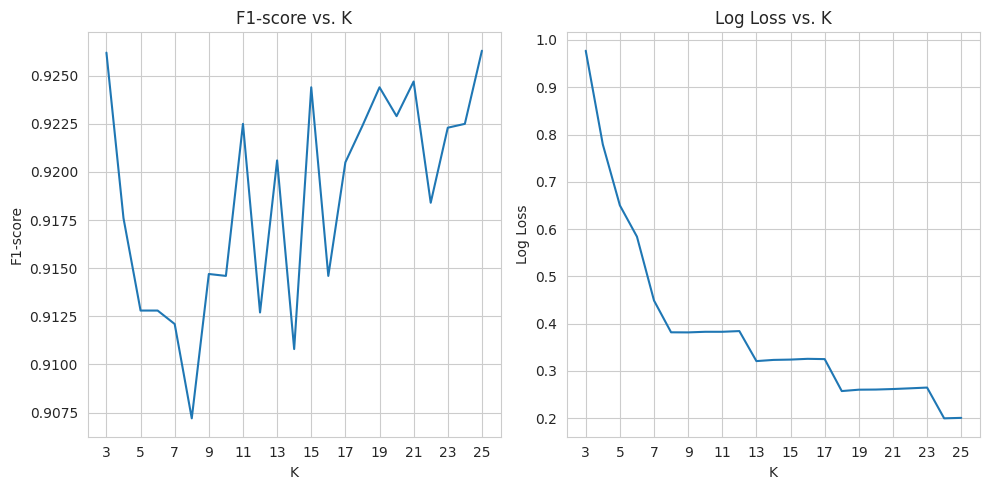

In [259]:
evaluate_k(25, metric="manhattan")

iii) Taking Distance as weights parameter k=25 has the best result:

k=25, accuracy=0.9340, f1=0.9343, loss=0.1947

k=3, accuracy=0.9280, f1=0.9283, loss=0.9705
k=4, accuracy=0.9300, f1=0.9302, loss=0.7702
k=5, accuracy=0.9220, f1=0.9223, loss=0.6403
k=6, accuracy=0.9240, f1=0.9240, loss=0.5736
k=7, accuracy=0.9160, f1=0.9161, loss=0.4403
k=8, accuracy=0.9200, f1=0.9201, loss=0.3739
k=9, accuracy=0.9160, f1=0.9163, loss=0.3748
k=10, accuracy=0.9220, f1=0.9225, loss=0.3757
k=11, accuracy=0.9260, f1=0.9265, loss=0.3760
k=12, accuracy=0.9240, f1=0.9244, loss=0.3776
k=13, accuracy=0.9260, f1=0.9267, loss=0.3138
k=14, accuracy=0.9300, f1=0.9305, loss=0.3159
k=15, accuracy=0.9280, f1=0.9284, loss=0.3169
k=16, accuracy=0.9260, f1=0.9263, loss=0.3182
k=17, accuracy=0.9300, f1=0.9300, loss=0.3178
k=18, accuracy=0.9260, f1=0.9263, loss=0.2515
k=19, accuracy=0.9320, f1=0.9321, loss=0.2539
k=20, accuracy=0.9280, f1=0.9284, loss=0.2546
k=21, accuracy=0.9320, f1=0.9323, loss=0.2556
k=22, accuracy=0.9300, f1=0.9303, loss=0.2571
k=23, accuracy=0.9300, f1=0.9303, loss=0.2584
k=24, accuracy=0.9320, f1=0.9322, loss=0.

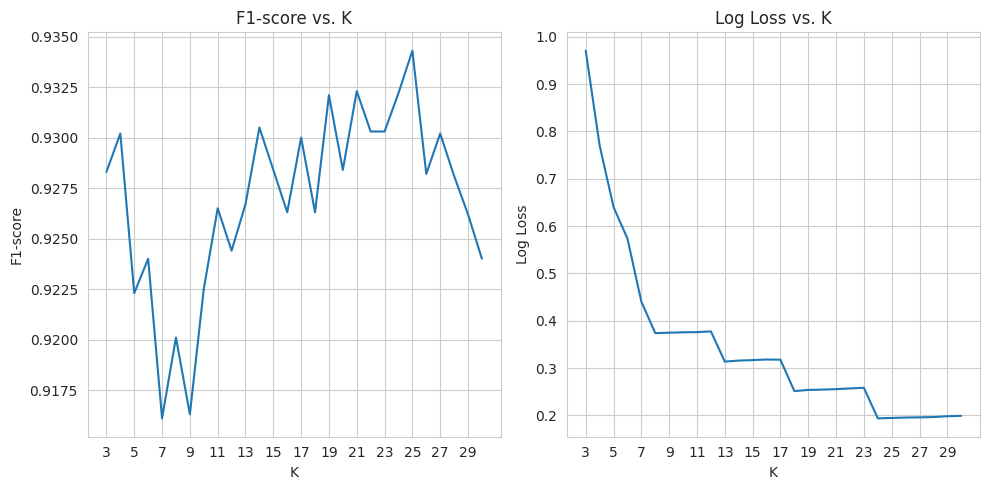

In [260]:
evaluate_k(30, metric="manhattan", weights="distance")

# Compare the best models

In [261]:
def evaluate_model(X, y, model):
  X_train, X_test = X
  y_train, y_test = y

  mms = MinMaxScaler()
  X_train = mms.fit_transform(X_train)
  X_test = mms.transform(X_test)

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  class_names = model.classes_

  cm = confusion_matrix(y_test, y_pred)
  report = classification_report(y_test, y_pred)

  print(report)

  sns.heatmap(
      cm,
      cbar=False,
      annot=True,
      cmap='Blues',
      fmt="d",
      xticklabels=class_names,
      yticklabels=class_names)
  plt.xlabel("Predicted Y")
  plt.ylabel("Y Test")
  plt.title("Confusion Matrix: fruit classification")
  plt.show()

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## 1) Evaluate k=9

              precision    recall  f1-score   support

     Arancia       0.81      0.81      0.81        21
      Banana       1.00      1.00      1.00        19
        Kiwi       0.80      0.89      0.84        18
        Mela       0.93      0.82      0.88        17
         Uva       1.00      1.00      1.00        25

    accuracy                           0.91       100
   macro avg       0.91      0.90      0.91       100
weighted avg       0.91      0.91      0.91       100



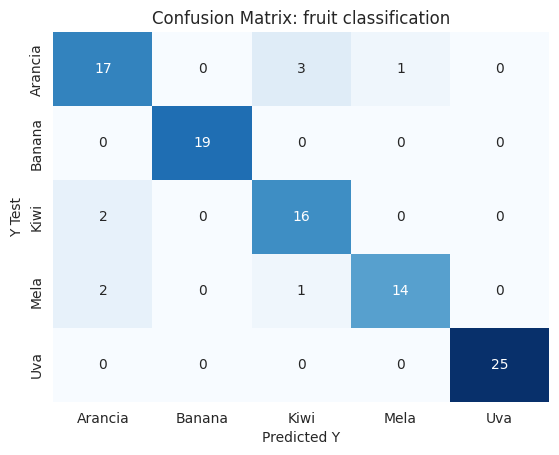

In [263]:
model = KNeighborsClassifier(n_neighbors=9)
evaluate_model((X_train, X_test), (y_train, y_test), model)

## 2) Evaluate k=3, k=15, Manhattan

**Manhattan Distance** (L1 distance): measures the distance as the sum of absolute differences along each dimension.

              precision    recall  f1-score   support

     Arancia       0.80      0.76      0.78        21
      Banana       1.00      1.00      1.00        19
        Kiwi       0.80      0.89      0.84        18
        Mela       0.94      0.88      0.91        17
         Uva       1.00      1.00      1.00        25

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



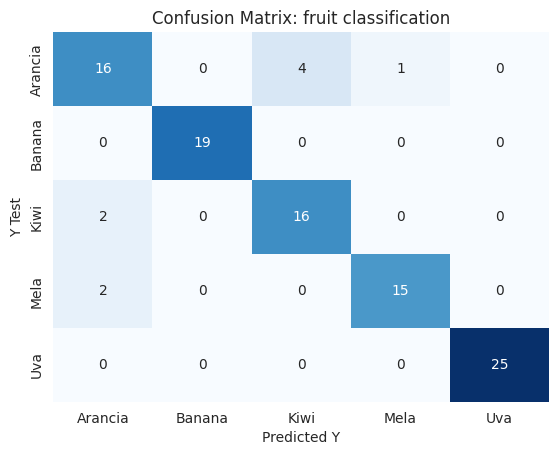

In [264]:
model = KNeighborsClassifier(n_neighbors=3, metric="manhattan")
evaluate_model((X_train, X_test), (y_train, y_test), model)

              precision    recall  f1-score   support

     Arancia       0.90      0.86      0.88        21
      Banana       1.00      1.00      1.00        19
        Kiwi       0.81      0.94      0.87        18
        Mela       0.93      0.82      0.88        17
         Uva       1.00      1.00      1.00        25

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.92       100
weighted avg       0.93      0.93      0.93       100



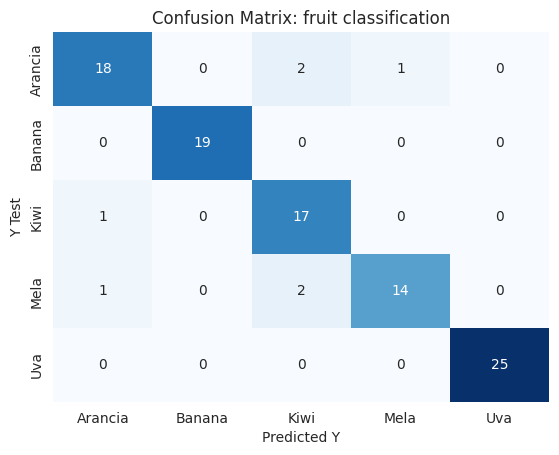

In [265]:
model = KNeighborsClassifier(n_neighbors=15, metric="manhattan")
evaluate_model((X_train, X_test), (y_train, y_test), model)

## 3) Evaluate k=25, Manhattan, Distance (weights)

**distance** : weight points by the inverse of their distance.
in this case, closer neighbors of a query point will have a
greater influence than neighbors which are further away.

              precision    recall  f1-score   support

     Arancia       0.89      0.81      0.85        21
      Banana       1.00      1.00      1.00        19
        Kiwi       0.81      0.94      0.87        18
        Mela       0.94      0.88      0.91        17
         Uva       1.00      1.00      1.00        25

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



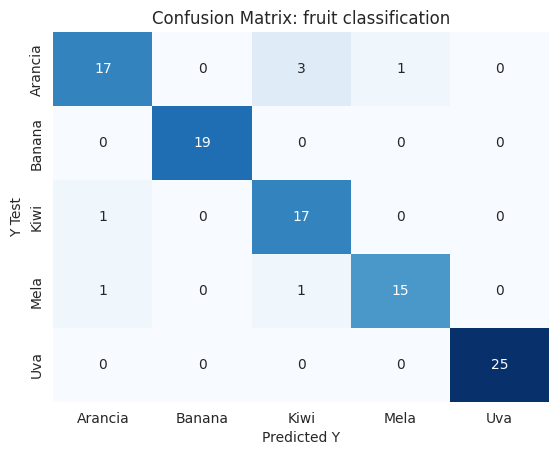

In [266]:
model = KNeighborsClassifier(n_neighbors=25, metric="manhattan", weights="distance")
evaluate_model((X_train, X_test), (y_train, y_test), model)

# Conclusion

In general, bananas and grapes are perfectly classified, because of those fruits' characteristics that help the model not to get confused.  
Oranges have a few misclassifications, mostly confused with kiwis and apples.    
Apples and kiwis show slight confusion with each other and with oranges.    

Overall, it's a very strong classifier with only minor overlap between fuits that have similar characteristics, especially diameter as we can see in the pairplot at the begining.

Finally we chose the model *k*=15 and metric Manhattan as optimal, with 93% accuracy.   
 Despite of it's sharing the same accuracy of the last model, here we're trying not to choose a *k* too big to avoid underfitting.

Pablo Di Marco